<a href="https://colab.research.google.com/github/ameliachoi/dacon-study-FUNDA/blob/master/dacon_funda_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON FUNDA : Predict Market Sales

## Index

1. Data load & Resampling
2. EDA
3. Modeling - Time Series
4. Modeling - Regression
5. Modeling - Deep Neural Network

## Data Field

- `store_id` : 상점 고유 아이디
- `card_id` : 사용한 카드의 고유 아이디
- `card_company` : 비식별화된 카드 회사
- `transacted_date` : 거래 날짜
- `transacted_time` : 거래 시간(시:분)
- `installment_term` : 할부 개월 수 (포인트 사용 시 (60개월 + 실제 할부개원)을 할부개월수에 기재한다)
- `region` : 상점의 지역
- `type_of_business` : 상점의 업종
- `amount` : 거래액(단위는 원이 아님)

---

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# basic setting
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# deep neural network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# setting
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format 


### Evaluate Metric

- MAE(Mean Absolute Error) : 절대값 오차의 평균
- Validation을 위한 함수 생성 및 make scorer


In [53]:
def mae(prediction, correct):
  prediction = np.array(prediction)
  correct = np.array(correct)

  difference = correct - prediction
  abs_val = abs(difference)

  score = abs_val.mean()

  return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

### Step 1. Data Load & Resampling

#### Issue

1. 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음

- 월 단위로 resampling 후, forecast 범위를 3개월로 지정해야 해결

2. 1967개의 `store_id`가 각각 trend와 seasonality를 가지고 있음

- 같은 알고리즘에서 각 `store_id`별로 parameter 조절

3. 예측 날짜는 2019-03 ~ 2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 존재함

- 마지막 날짜부터 3개월만 예측하다 제출

- 예측 기간이 길어질수록 오차가 크게 발생해 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

In [54]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data09/funda_train.csv')
df_sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data09/submission.csv')

In [55]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [56]:
df_train.shape, df_sub.shape

((6556613, 9), (1967, 2))

In [57]:
df_train.columns

Index(['store_id', 'card_id', 'card_company', 'transacted_date',
       'transacted_time', 'installment_term', 'region', 'type_of_business',
       'amount'],
      dtype='object')

In [58]:
# datetime으로 데이터 타입 바꾸기
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])

In [59]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [60]:
frame_info = [(col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5]) for col in df_train.columns]
df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])

In [61]:
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


#### 시계열 분석을 위해 date 정보 index로 변환

In [62]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000


#### 시간 단위로 나뉘어져 있는 데이터 일단위로 resampling

- `store_id` / `region` / `type_of_business` :  기존과 동일
- `day_of_week` : 각 요일을 나타내는 숫자. 월요일은 0, 일요일은 6.
- `business_day` : working day 여부. 1이면 working day.
- `num_of_pay` : 일 결제 건수. `card_id`의 count로 생성
- `num_of_revisit` : 단골 방문 횟수. `card_id`의 value 중 count >= 3 value의 결제 건수
- `installment_term` : 일 총 할부 개월 수, 기존 `installment_term`의 합. (수정)
- `amount` : 일 매출액. 기존 amount의 합. (수정)

In [63]:
def resample_day(train_df):
  df_day = pd.DataFrame()

  for i in train_df['store_id'].unique():
    df_num = train_df[train_df['store_id']==i] # store_id 횟수 count

    # 'card_id'의 일별 counting을 통해 일 거래 횟수 확인
    # resample 함수의 rule='d'인 경우 일별 그룹이 가능해지고, count함수를 통해 unique값별로 빈도수 생성
    count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay')

    # 'card_id' value count >= 3이면 단골로 판단하고 단골 방문 횟수 확인
    revisit_idx = df_num['card_id'].value_counts().reset_index().query('card_id > 2')['index'].values
    revisit_ct = df_num[df_num['card_id'].isin(revisit_idx)]['card_id'].resample(rule='d').count().rename('num_of_revisit')

    # 할부 개월수와 매출액은 일단위로 합
    sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum()
    df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

    # 매장 id, 지역, 업종 분류 추가
    df_num_day.insert(0, 'store_id', i)
    df_num_day.insert(4, 'region', df_num[df_num['store_id']==i]['region'].unique()[0])
    df_num_day.insert(5, 'type_of_business', df_num[df_num['store_id']==i]['type_of_business'].unique()[0])

    df_day = pd.concat([df_day, df_num_day], axis=0)

  df_day.insert(1, 'day_of_week', df_day.index.dayofweek) #df_day가 일별로 묶여 index에 들어가있음
  df_day.insert(2, 'business_day', df_day['day_of_week'].replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
  df_day['num_of_revisit'].fillna(0, inplace=True)

  return df_day

In [64]:
%%time
df_day = resample_day(df_train)

CPU times: user 3min 23s, sys: 3.29 s, total: 3min 26s
Wall time: 3min 26s


In [65]:
df_day.head()

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143


In [66]:
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [67]:
df_day.to_csv('preprocessed.csv')

#### 각 column간 상관관계 확인

In [68]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


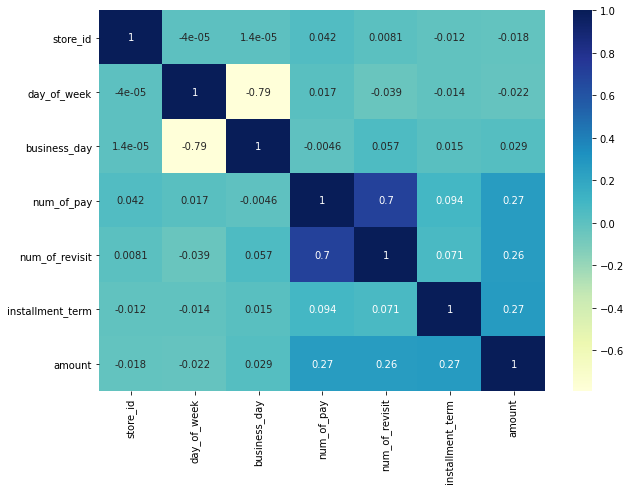

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True, cmap='YlGnBu')

#### 모델링을 위해 월 단위로 resampling

In [70]:
df_day.head(30)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143
2016-06-06,0,0,1,4,2.00000,0,NaN,기타 미용업,17285.71429
2016-06-07,0,1,1,0,0.00000,0,NaN,기타 미용업,0.00000
2016-06-08,0,2,1,0,0.00000,0,NaN,기타 미용업,0.00000
2016-06-09,0,3,1,9,5.00000,0,NaN,기타 미용업,35000.00000


In [82]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day['store_id'] == i]
        
        # 결측값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        # date_range 함수를 이용하면 start와 end 날짜 사이의 모든 날짜를 담은 변수를 생성할 수 있음
        # concat 함수로 이전 이후 한 달 row를 추가로 붙임
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), 
                                  end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), 
                                 end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
        
        # strftime 함수는 datetime 형식의 모양을 변경해주는 것 (연-월 단위)
        # 첫 달과 마지막 달에 1을 넣어둠
        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1
        
        # 매출액이 0이 아닌 데이터에 대해 요일 카운트와 business day합을 넣음
        tot_day = df_set[df_set.amount != 0]['day_of_week'].resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0]['business_day'].resample(rule='m').sum().rename('real_business_day')
        
        # 이전 이후 달 삭제(drop 함수 이용해 인덱스 기준으로 삭제)
        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)
        
        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set['region'].values[0])
        df.insert(7, 'type_of_business', df_set['type_of_business'].values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [83]:
%%time
df_month = resample_month(df_day)

CPU times: user 1min 13s, sys: 223 ms, total: 1min 13s
Wall time: 1min 13s


In [84]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [85]:
# 전체 row 개수 대비 컬럼별 결측값 row 개수 비율 확인
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


각각 34%. 56%에 이르는 null값을 채우는 것은 너무 어렵고, 채워도 오차가 클 것으로 예상하여 `region`과 `type_of_business` 삭제

In [86]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [87]:
df_month.to_csv('monthly-processed.csv')

In [89]:
df_month = pd.read_csv('/content/monthly-processed.csv')
df_month.head()

,Unnamed: 0,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
0,2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000
1,2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2,2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857
3,2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286
4,2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143


In [90]:
df_month.rename(columns={'Unnamed: 0' : 'transacted_date'}, inplace=True)
df_month['transacted_date'] = pd.to_datetime(df_month['transacted_date'])
df_month = df_month.set_index('transacted_date')

In [91]:
print(df_month.shape)
df_month.head()

(60915, 7)


,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
transacted_date,,,,,,,
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143


---

### Step 2. EDA

#### 변수의 describe 확인

In [92]:
df_month.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000
mean,1050.48428,21.06987,15.89640,107.63544,40.01136,14.87540,1123187.83063
std,617.48320,7.75327,5.63136,101.24413,43.88133,33.42161,1753567.15171
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-514285.71429
25%,515.00000,16.00000,12.00000,32.00000,11.00000,0.00000,339642.85714
50%,1039.00000,23.00000,17.00000,73.00000,26.00000,3.00000,710714.28571
75%,1587.00000,28.00000,21.00000,159.00000,54.00000,14.00000,1344650.00000
max,2136.00000,31.00000,23.00000,2186.00000,2154.00000,1125.00000,61429316.14286


#### target 변수의 정규성 확인

Skewness : 0.48245510908400707


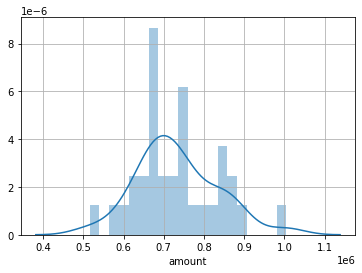

Skewness : 0.510252105069473


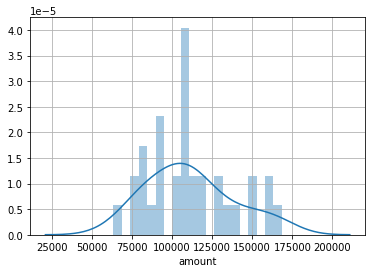

Skewness : 0.9982599271676977


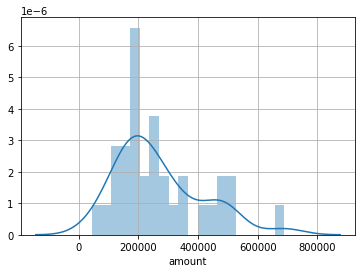

In [94]:
for i in df_month['store_id'].unique()[:3]:
  print('Skewness :', df_month[df_month['store_id'] == i]['amount'].skew())
  sns.distplot(df_month[df_month['store_id'] == i].amount, bins=20)
  plt.grid()
  plt.show()

log scale : -0.5308009496851174


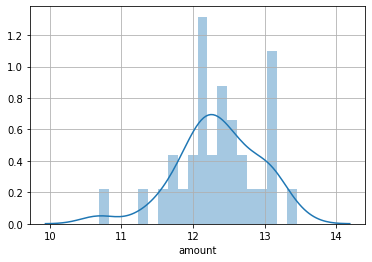

log scale : -0.5308009496851174


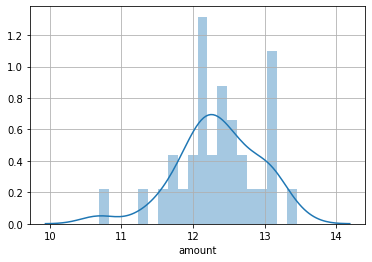

log scale : -0.5308009496851174


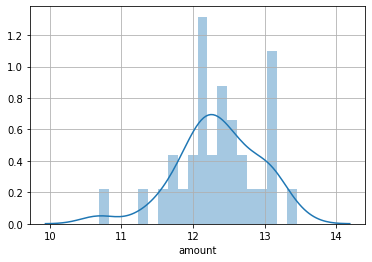

In [95]:
for i in df_month['store_id'].unique()[:3]:
    print('log scale :', np.log(df_month[df_month.store_id == 2].amount).skew())
    sns.distplot(np.log(df_month[df_month.store_id == 2].amount), bins=20)
    plt.grid()
    plt.show()

#### 변수 별 분포 시각화

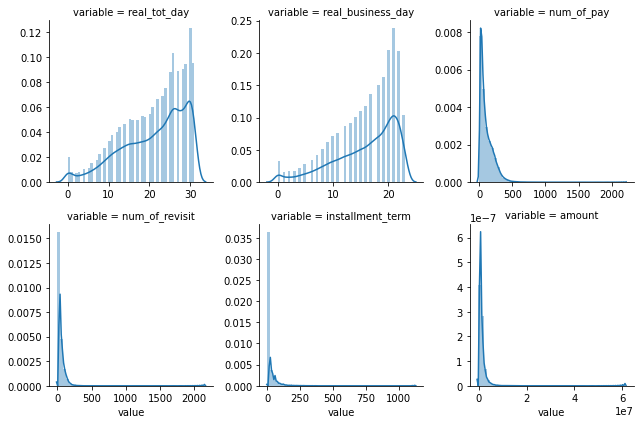

In [98]:
# melt 함수를 이용해 컬럼을 row 단위로 변경해줌
# 상점 id 빼고 전부 melt
# melt하면 컬럼 6개 variable이라는 컬럼의 값으로 들어가고, 각 컬럼의 값들은 value라는 컬럼의 값으로 들어감

f = pd.melt(df_month, value_vars=df_month.columns[1:])
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')
plt.show()

#### 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인 (첫 7개 상점)

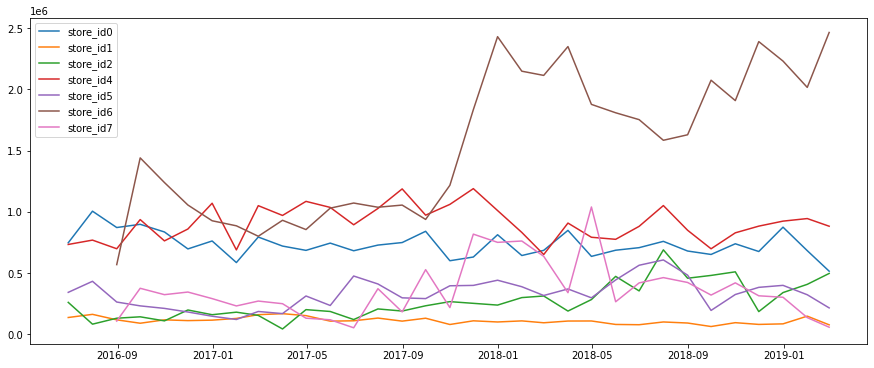

In [100]:
plt.figure(figsize=(15, 6))
for i in df_month.store_id.unique()[:7]:
  plt.plot(df_month[df_month['store_id'] == i].index,
           df_month[df_month['store_id'] == i].amount,
           label = 'store_id{}'.format(i))
plt.legend()

각 `store_id`별로 다른 trend와 seasonality, scale을 가지는 것을 확인

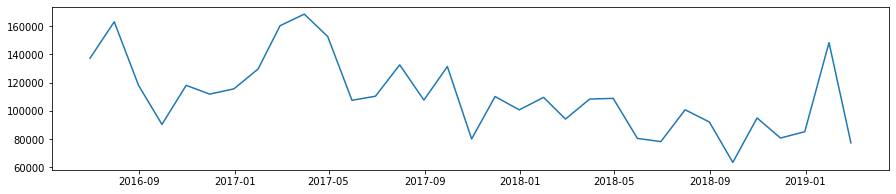

In [101]:
plt.figure(figsize=(15, 3))
plt.plot(df_month[df_month.store_id == 1].index,
         df_month[df_month.store_id == 1].amount)

#### 다른 변수들이 'amount'와 같은 패턴을 보이는 지 확인

In [102]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame['store_id'] == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

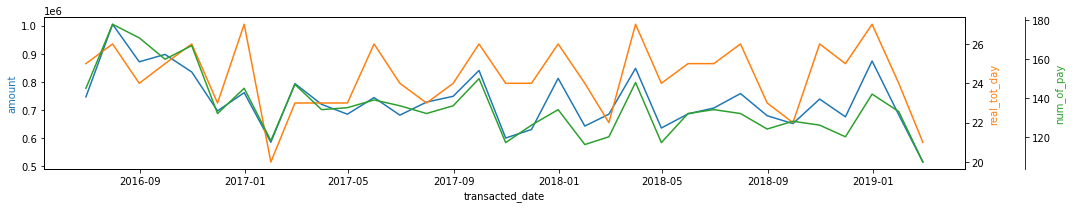

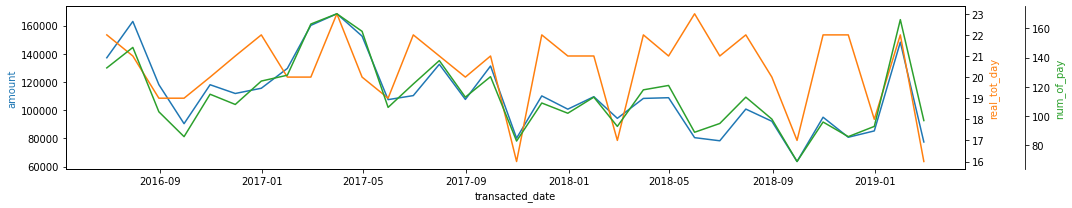

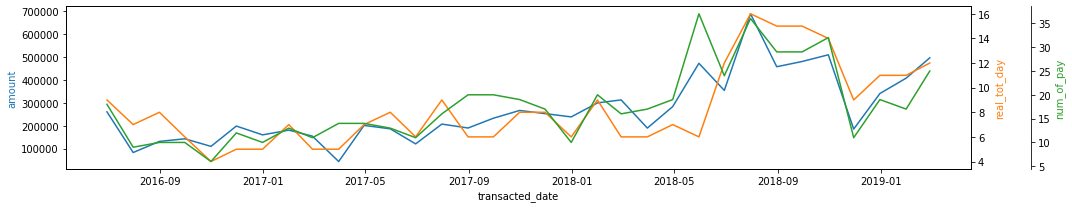

In [103]:
# 상점 id별로 매출액, 총 영업일, 결제 횟수 비교
for i in df_month.store_id.unique()[:3]:
  plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'num_of_pay'])

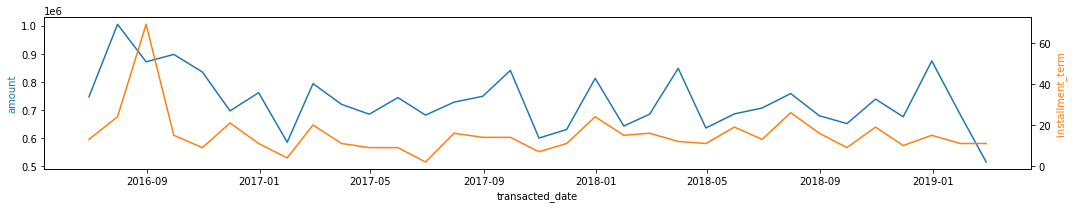

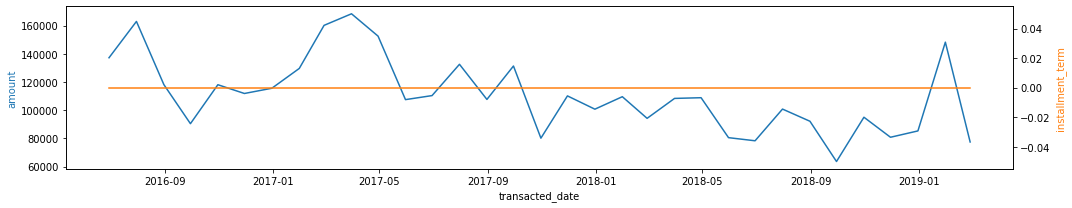

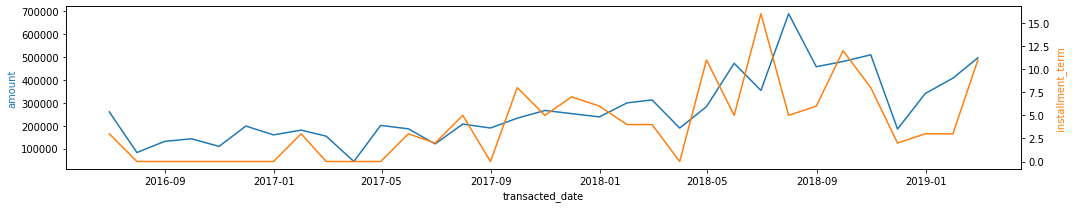

In [104]:
# 상점 id별로 매출액, 할부개월수 비교
for i in df_month.store_id.unique()[:3]:
  plot_model_graph(df_month, i, 'transacted_date', ['amount', 'installment_term'])